## Deep Learning Multiclass Challenge (CAD Project)

Author: **Muhammad Zain Amin**
<br>
Erasmus Mundus Joint Master Degree in Medical Imaging and Applications (MAIA)
<br>
University of Girona, Spain

#### Libraries

In [ ]:
import copy
import time
import sys
import logging
import cv2 as cv
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image, ImageOps
from typing import Optional, Sequence

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import models, transforms
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import accuracy_score, balanced_accuracy_score, cohen_kappa_score, confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from skimage import io

#### Import Functions and Classes

In [20]:
from imshow import imshow
from visualize_model import visualize_model
from focal_loss import FocalLoss
from train_model import train_model
from test_model import test_model
from plot_confusion_matrix import plot_confusion_matrix
from plot_roc import plot_roc
from Imbalanced_Dataset_Sampler import ImbalancedDatasetSampler 
from Challenge_2_Dataset import Challenge2Dataset
from Data_Samples import get_samples_count
from models import ModelFactory

#### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset Directories

In [ ]:
# Image directories
train_img_folder = '/content/drive/MyDrive/CAD/Dataset/train/train'
val_img_folder = '/content/drive/MyDrive/CAD/Dataset/val/val'
test_img_folder = '/content/drive/MyDrive/CAD/Dataset/test'

# CSV paths
train_csv_path = '/content/drive/MyDrive/CAD/Dataset/train_labels.csv'
val_csv_path = '/content/drive/MyDrive/CAD/Dataset/val_labels.csv'
test_csv_path = '/content/drive/MyDrive/CAD/Dataset/test_ids.csv'

#### Parameters

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" 
NEW_SIZE = 256
TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 2
MU = [0.6138, 0.5056, 0.4985]
STD = [0.1611, 0.1672, 0.1764]

#### Data Transformations

In [ ]:
img_transforms = transforms.Compose([
                                      transforms.Resize(NEW_SIZE+4),
                                      transforms.CenterCrop(NEW_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean= MU, std=STD)
                                  ])

In [ ]:
dataset_train = Challenge2Dataset(csv_file=train_csv_path,
                             image_folder= train_img_folder,
                             img_transform = img_transforms,
                             augment = True)

In [ ]:
dataset_val = Challenge2Dataset(csv_file=val_csv_path,
                            image_folder= val_img_folder,
                            img_transform = img_transforms,
                            augment=False)


#### Data Loaders

In [ ]:
y = dataset_train.get_labels()
class_weights= class_weight.compute_class_weight(class_weight = 'balanced', classes= np.unique(y), y= np.array(y))
class_weights =  torch.tensor(class_weights).float().to(DEVICE)

In [ ]:
# Balanced training dataloader
mean_samples = get_samples_count(dataset_train.get_labels(), 'mean') # perform undersampling
data_sampler = ImbalancedDatasetSampler(dataset_train, indices=None, num_samples=mean_samples, replacement = True)
train_loader_balanced = DataLoader(dataset_train, sampler=data_sampler, num_workers=NUM_WORKERS,
                             batch_size=TRAIN_BATCH_SIZE)

In [ ]:
val_loader_shuff = DataLoader(dataset_val, batch_size=8, num_workers=NUM_WORKERS, shuffle=True)

In [ ]:
# dataloaders with the original number of samples in the dataset
train_loader = DataLoader(dataset_train, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=VAL_BATCH_SIZE, num_workers=NUM_WORKERS)


In [ ]:
dataloaders = {"train": train_loader,"val": val_loader}
dataloaders_balanced = {"train": train_loader_balanced,"val": val_loader}

# Training and Results

#### Swin S V2 Model

In [ ]:
logging.basicConfig(filename="/content/drive/MyDrive/CAD/Swin/swin_s_v2_ce.txt", level=logging.INFO,format='[%(asctime)s.%(msecs)03d] %(message)s', datefmt='%H:%M:%S', force=True)
logging.getLogger().addHandler(logging.StreamHandler(sys.stdout))
writer_path = '/content/drive/MyDrive/CAD/Swin'

In [ ]:
LR = 1e-4
LR_PATIENCE = 7
ES_PATIENCE = 12
EPOCHS = 100
WD = 1e-8
model_factory = ModelFactory()
swin = model_factory.make_swin_v2(True, DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(swin.parameters(), lr = LR, weight_decay=WD)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= LR_PATIENCE, factor = 0.1, mode="min")

Downloading: "https://download.pytorch.org/models/swin_v2_s-637d8ceb.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_s-637d8ceb.pth
100%|██████████| 191M/191M [00:11<00:00, 17.1MB/s]


In [ ]:
logging.info('Model:swin_s_v2, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling')

Model:swin_s_v2, LR: 1e-4, LR patience = 7, loss: CE, optim: ADAM, lr_sched: ReduceOnPlat, WD = 1e-8, without sampling


In [ ]:
#number of samples in each set
dataset_sizes = {
    'train': len(dataset_train),
    'val':len(dataset_val),
}

In [ ]:
checkpoint_p = '/content/drive/MyDrive/CAD/swin_s_v2_ce.pth'
swin = train_model(swin, dataloaders, criterion, optimizer, lr_scheduler, checkpoint_p, early_stop_patience=ES_PATIENCE, num_epochs=EPOCHS, writer_path = writer_path)

Epoch 1/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.38it/s]

train epoch 1 : loss : 0.5192, acc: 0.8003, kappa: 0.6259



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 1 : loss : 0.3966, acc: 0.8693, kappa: 0.7551



Epoch 2/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 2 : loss : 0.3997, acc: 0.8544, kappa: 0.7293



100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

val epoch 2 : loss : 0.3159, acc: 0.8772, kappa: 0.7748



Epoch 3/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train epoch 3 : loss : 0.3442, acc: 0.8660, kappa: 0.7537



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 3 : loss : 0.2954, acc: 0.9008, kappa: 0.8162



Epoch 4/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 4 : loss : 0.3057, acc: 0.8855, kappa: 0.7903



100%|██████████| 20/20 [00:24<00:00,  1.24s/it]

val epoch 4 : loss : 0.2600, acc: 0.9055, kappa: 0.8285



Epoch 5/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 5 : loss : 0.2727, acc: 0.9032, kappa: 0.8232



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 5 : loss : 0.3170, acc: 0.8953, kappa: 0.8057



Epoch 6/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 6 : loss : 0.2520, acc: 0.9095, kappa: 0.8353



100%|██████████| 20/20 [00:24<00:00,  1.25s/it]

val epoch 6 : loss : 0.2686, acc: 0.9063, kappa: 0.8258



Epoch 7/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 7 : loss : 0.2380, acc: 0.9150, kappa: 0.8449



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 7 : loss : 0.2446, acc: 0.9142, kappa: 0.8448



Epoch 8/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 8 : loss : 0.2042, acc: 0.9278, kappa: 0.8689



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 8 : loss : 0.2386, acc: 0.9165, kappa: 0.8505



Epoch 9/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train epoch 9 : loss : 0.1794, acc: 0.9372, kappa: 0.8864



100%|██████████| 20/20 [00:27<00:00,  1.39s/it]

val epoch 9 : loss : 0.3053, acc: 0.9094, kappa: 0.8313



Epoch 10/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 10 : loss : 0.1809, acc: 0.9355, kappa: 0.8830



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

val epoch 10 : loss : 0.2051, acc: 0.9315, kappa: 0.8745



Epoch 11/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train epoch 11 : loss : 0.1727, acc: 0.9376, kappa: 0.8870



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 11 : loss : 0.2850, acc: 0.9047, kappa: 0.8305



Epoch 12/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train epoch 12 : loss : 0.1427, acc: 0.9510, kappa: 0.9114



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 12 : loss : 0.2527, acc: 0.9307, kappa: 0.8737



Epoch 13/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 13 : loss : 0.1505, acc: 0.9481, kappa: 0.9059



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

val epoch 13 : loss : 0.1681, acc: 0.9425, kappa: 0.8954



Epoch 14/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 14 : loss : 0.1190, acc: 0.9581, kappa: 0.9244



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 14 : loss : 0.1753, acc: 0.9433, kappa: 0.8974



Epoch 15/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train epoch 15 : loss : 0.1388, acc: 0.9473, kappa: 0.9048



100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

val epoch 15 : loss : 0.2296, acc: 0.9283, kappa: 0.8714



Epoch 16/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 16 : loss : 0.1283, acc: 0.9553, kappa: 0.9192



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 16 : loss : 0.1773, acc: 0.9465, kappa: 0.9033



Epoch 17/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 17 : loss : 0.1127, acc: 0.9630, kappa: 0.9333



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 17 : loss : 0.1720, acc: 0.9441, kappa: 0.8998



Epoch 18/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.37it/s]

train epoch 18 : loss : 0.1106, acc: 0.9587, kappa: 0.9255



100%|██████████| 20/20 [00:27<00:00,  1.35s/it]

val epoch 18 : loss : 0.1980, acc: 0.9441, kappa: 0.8979



Epoch 19/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train epoch 19 : loss : 0.1124, acc: 0.9614, kappa: 0.9304



100%|██████████| 20/20 [00:25<00:00,  1.27s/it]

val epoch 19 : loss : 0.1747, acc: 0.9425, kappa: 0.8957



Epoch 20/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train epoch 20 : loss : 0.1128, acc: 0.9595, kappa: 0.9269



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 20 : loss : 0.1736, acc: 0.9402, kappa: 0.8929



Epoch 21/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 21 : loss : 0.1017, acc: 0.9638, kappa: 0.9348



100%|██████████| 20/20 [00:26<00:00,  1.30s/it]

val epoch 21 : loss : 0.1918, acc: 0.9323, kappa: 0.8772



Epoch 22/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train epoch 22 : loss : 0.0551, acc: 0.9801, kappa: 0.9642



100%|██████████| 20/20 [00:26<00:00,  1.32s/it]

val epoch 22 : loss : 0.1353, acc: 0.9606, kappa: 0.9289



Epoch 23/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train epoch 23 : loss : 0.0353, acc: 0.9872, kappa: 0.9770



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 23 : loss : 0.1307, acc: 0.9669, kappa: 0.9405



Epoch 24/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.29it/s]

train epoch 24 : loss : 0.0328, acc: 0.9888, kappa: 0.9798



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 24 : loss : 0.1344, acc: 0.9622, kappa: 0.9318



Epoch 25/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.34it/s]

train epoch 25 : loss : 0.0261, acc: 0.9913, kappa: 0.9844



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 25 : loss : 0.1314, acc: 0.9709, kappa: 0.9478



Epoch 26/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 26 : loss : 0.0266, acc: 0.9909, kappa: 0.9837



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 26 : loss : 0.1399, acc: 0.9638, kappa: 0.9348



Epoch 27/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train epoch 27 : loss : 0.0228, acc: 0.9925, kappa: 0.9865



100%|██████████| 20/20 [00:26<00:00,  1.31s/it]

val epoch 27 : loss : 0.1396, acc: 0.9646, kappa: 0.9363



Epoch 28/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train epoch 28 : loss : 0.0275, acc: 0.9929, kappa: 0.9873



100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

val epoch 28 : loss : 0.1340, acc: 0.9646, kappa: 0.9363



Epoch 29/100
---------------


100%|██████████| 318/318 [02:14<00:00,  2.36it/s]

train epoch 29 : loss : 0.0182, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 29 : loss : 0.1337, acc: 0.9685, kappa: 0.9435



Epoch 30/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 30 : loss : 0.0202, acc: 0.9941, kappa: 0.9894



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 30 : loss : 0.1282, acc: 0.9693, kappa: 0.9450



Epoch 31/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train epoch 31 : loss : 0.0135, acc: 0.9961, kappa: 0.9929



100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

val epoch 31 : loss : 0.1376, acc: 0.9677, kappa: 0.9421



Epoch 32/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 32 : loss : 0.0153, acc: 0.9947, kappa: 0.9904



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 32 : loss : 0.1466, acc: 0.9709, kappa: 0.9477



Epoch 33/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.32it/s]

train epoch 33 : loss : 0.0197, acc: 0.9939, kappa: 0.9890



100%|██████████| 20/20 [00:25<00:00,  1.29s/it]

val epoch 33 : loss : 0.1498, acc: 0.9685, kappa: 0.9434



Epoch 34/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train epoch 34 : loss : 0.0135, acc: 0.9955, kappa: 0.9919



100%|██████████| 20/20 [00:26<00:00,  1.35s/it]

val epoch 34 : loss : 0.1443, acc: 0.9669, kappa: 0.9408



Epoch 35/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 35 : loss : 0.0146, acc: 0.9951, kappa: 0.9911



100%|██████████| 20/20 [00:27<00:00,  1.36s/it]

val epoch 35 : loss : 0.1436, acc: 0.9685, kappa: 0.9435



Epoch 36/100
---------------


100%|██████████| 318/318 [02:18<00:00,  2.30it/s]

train epoch 36 : loss : 0.0115, acc: 0.9951, kappa: 0.9911



100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

val epoch 36 : loss : 0.1576, acc: 0.9685, kappa: 0.9437



Epoch 37/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.33it/s]

train epoch 37 : loss : 0.0127, acc: 0.9961, kappa: 0.9929



100%|██████████| 20/20 [00:27<00:00,  1.38s/it]

val epoch 37 : loss : 0.1634, acc: 0.9669, kappa: 0.9408



Epoch 38/100
---------------


100%|██████████| 318/318 [02:13<00:00,  2.38it/s]

train epoch 38 : loss : 0.0134, acc: 0.9945, kappa: 0.9901



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 38 : loss : 0.1472, acc: 0.9724, kappa: 0.9507



Epoch 39/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.32it/s]

train epoch 39 : loss : 0.0144, acc: 0.9943, kappa: 0.9897



100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

val epoch 39 : loss : 0.1470, acc: 0.9717, kappa: 0.9493



Epoch 40/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 40 : loss : 0.0121, acc: 0.9955, kappa: 0.9919



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 40 : loss : 0.1464, acc: 0.9724, kappa: 0.9507



Epoch 41/100
---------------


100%|██████████| 318/318 [02:16<00:00,  2.34it/s]

train epoch 41 : loss : 0.0073, acc: 0.9974, kappa: 0.9954



100%|██████████| 20/20 [00:27<00:00,  1.37s/it]

val epoch 41 : loss : 0.1480, acc: 0.9717, kappa: 0.9492



Epoch 42/100
---------------


100%|██████████| 318/318 [02:17<00:00,  2.31it/s]

train epoch 42 : loss : 0.0103, acc: 0.9970, kappa: 0.9947



100%|██████████| 20/20 [00:25<00:00,  1.30s/it]

val epoch 42 : loss : 0.1450, acc: 0.9724, kappa: 0.9507



Epoch 43/100
---------------


100%|██████████| 318/318 [02:15<00:00,  2.35it/s]

train epoch 43 : loss : 0.0117, acc: 0.9963, kappa: 0.9933



100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

val epoch 43 : loss : 0.1457, acc: 0.9709, kappa: 0.9478


EARLY STOP AFTER 43 EPOCHS
Training complete in 119m 27s
Best val loss: 0.128225
Best val Kappa: 0.9507225875685671


#### Load the saved model

In [ ]:
swin_s_best_2 = model_factory.make_swin_v2(False, DEVICE)
swin_s_best_2.load_state_dict(torch.load('/content/drive/MyDrive/CAD/swin_s_v2_ce_best.pth'))

<All keys matched successfully>

In [ ]:
since = time.time()
swin_s_best_2.eval()
running_labels = []
running_preds = []
outputs_all = []

# Iterate over data.
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs = batch["image"].to(DEVICE)
        labels = batch["label"].to(DEVICE)
        outputs = swin_s_best_2(inputs)
        _, preds = torch.max(outputs, 1)
        running_labels = running_labels + labels.int().cpu().tolist()
        running_preds = running_preds + preds.int().cpu().tolist()
        probas = F.softmax(outputs, dim=1)
        outputs_all.append(probas.cpu().numpy())
    test_kappa = cohen_kappa_score(running_labels, running_preds)
    test_acc = accuracy_score(running_labels, running_preds)
    print(f'Test Acc: {test_acc:.4f}, kappa: {test_kappa:.4f}')

    time_elapsed = time.time() - since
    print(f'Testing complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

100%|██████████| 20/20 [00:25<00:00,  1.25s/it]

Test Acc: 0.9724, kappa: 0.9507
Testing complete in 0m 25s


Confusion matrix, without normalization
[[660   8  10]
 [  7 486   5]
 [  2   3  89]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

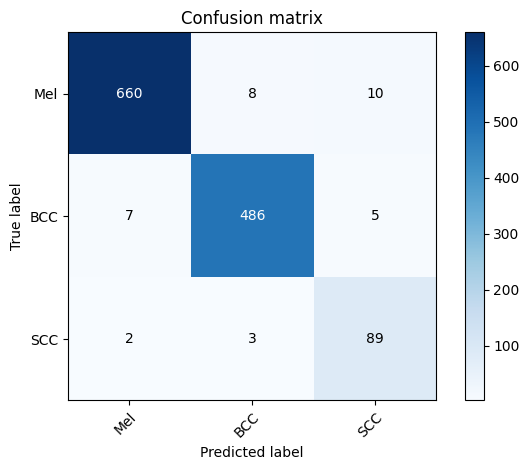

In [ ]:
plot_confusion_matrix(running_labels, running_preds, ['Mel', 'BCC', 'SCC'],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

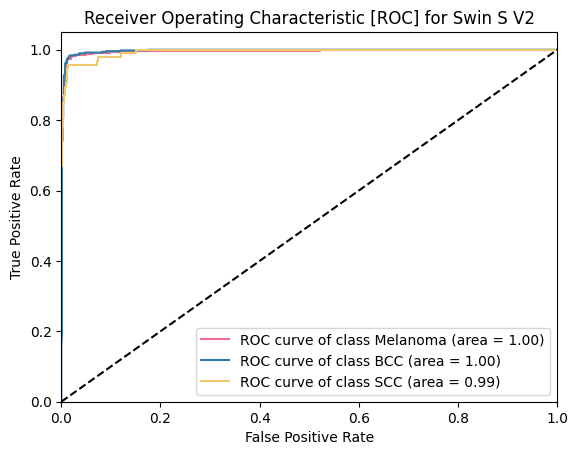

{0: 0.9956026269632463, 1: 0.9967395488690514, 2: 0.9942014039658417}

In [ ]:
probas = np.vstack(outputs_all)
plot_roc(running_labels, probas, True, 'Swin S V2')

In [ ]:
test_df = pd.read_csv(test_csv_path)
test_ids = []
test_preds = []
for i, row in test_df.iterrows():
  img_id = '/' + row['Image_ID'] 

  img_path = test_img_folder + img_id + '.jpg' 
  image = Image.open(img_path)  
  image = img_transforms(image).unsqueeze(0).to(DEVICE)

  outputs_1 = swin_s_best_2(image)
  outputs = outputs_1
  _, preds = torch.max(outputs, 1)
  test_preds = test_preds + preds.int().cpu().tolist()
  test_ids.append(img_id)
  print(f"Image {row['Image_ID']} done")

Image xxx01102 done
Image xxx01122 done
Image xxx01137 done
Image xxx01096 done
Image xxx01126 done
Image xxx01121 done
Image xxx01089 done
Image xxx01095 done
Image xxx01087 done
Image xxx01109 done
Image xxx01110 done
Image xxx01107 done
Image xxx01091 done
Image xxx01125 done
Image xxx01082 done
Image xxx01101 done
Image xxx01156 done
Image xxx01195 done
Image xxx01158 done
Image xxx01180 done
Image xxx01181 done
Image xxx01189 done
Image xxx01188 done
Image xxx01148 done
Image xxx01162 done
Image xxx01182 done
Image xxx01147 done
Image xxx01179 done
Image xxx01138 done
Image xxx01170 done
Image xxx01171 done
Image xxx01174 done
Image xxx01160 done
Image xxx01164 done
Image xxx01161 done
Image xxx01173 done
Image xxx01153 done
Image xxx01178 done
Image xxx01145 done
Image xxx01152 done
Image xxx01142 done
Image xxx01191 done
Image xxx01143 done
Image xxx01193 done
Image xxx01155 done
Image xxx01194 done
Image xxx01200 done
Image xxx01184 done
Image xxx01196 done
Image xxx01144 done


#### Load the saved model

In [ ]:
test_dict = {'img_id': test_ids, 'prediction': test_preds}
test_inf_df = pd.DataFrame(test_dict)
test_inf_df.to_csv('/content/drive/MyDrive/CAD/test_results_swin_s_v2.csv')